# *Setup and Imports*

In [ ]:
# ==============================================================================
# Cell 1: Environment Setup and Library Imports
# ==============================================================================

# Install external deep learning and utility libraries
!pip install pytorch-lightning efficientnet-pytorch grad-cam

# Core Data Handling and Utilities
import pandas as pd
import numpy as np
import os
import random
import glob
from sklearn.model_selection import train_test_split

# Image Handling
from PIL import Image # Primary library for image loading
import cv2 # OpenCV for potential image manipulation/color conversion

# Deep Learning Framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# PyTorch Lightning for streamlined training
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Model Architecture (EfficientNet for feature extraction)
from efficientnet_pytorch import EfficientNet

# Evaluation and Visualization
from sklearn.metrics import roc_auc_score, f1_score # For metrics calculation
import matplotlib.pyplot as plt
import seaborn as sns

# Grad-CAM for model explainability
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

print("Imports complete.")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━

#  *Configuration and Seed*

In [ ]:
# ==============================================================================
# Cell 2: Configuration Dictionary and Reproducibility Seed
# ==============================================================================

# Global configuration dictionary for hyperparameters and paths
CONFIG = {
    'SEED': 42,           # Random seed for reproducibility
    'IMG_SIZE': 512,      # Target image size for resizing (512x512)
    'BATCH_SIZE': 32,     # Batch size for DataLoader
    'NUM_WORKERS': 4,     # Number of data loading workers
    'EPOCHS': 15,         # Total training epochs
    'LR': 1e-4,           # Learning rate
    'N_CLASSES': 14,      # Number of output classes (for multi-label classification)
    'MODEL_NAME': 'efficientnet-b0', # Pre-trained model architecture to use
    'DATA_ROOT': '../input/vinbigdata-512-image-dataset', # Root directory for data
    'TRAIN_PNG_DIR': '../input/vinbigdata-512-image-dataset/vinbigdata/train', # Directory containing training images
    'TRAIN_CSV': '../input/vinbigdata-512-image-dataset/vinbigdata/train.csv' # Path to training metadata CSV
}

# Function to set seeds across Python, Numpy, and PyTorch for deterministic results
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Enforce determinism
    torch.backends.cudnn.benchmark = False    # Disable benchmark for determinism

seed_everything(CONFIG['SEED'])
print("Configuration and Seed set.")

Configuration and Seed set.


# *Data Loading and Label Processing*

In [ ]:
# ==============================================================================
# Cell 3: Data Loading, Label Processing (Multi-Label Target), and Split
# ==============================================================================

df = pd.read_csv(CONFIG['TRAIN_CSV']) # Load the training metadata CSV

# 1. Get unique classes and create mapping (14 classes including 'No Finding')
class_names = sorted(df['class_name'].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for i, name in enumerate(class_names)}

# 2. Filter to get the list of unique findings (labels) per image_id
# Group by image_id and collect all unique class names present in that image
label_series = df.groupby('image_id')['class_name'].unique().apply(
    # Convert class names to their numerical indices
    lambda names: [class_to_idx[name] for name in names]
)

# Convert the Series to a DataFrame with image_id and the list of indices
image_class_labels = label_series.to_frame(name='labels').reset_index()


# 3. Create the multi-hot encoded target vector (14 classes)
image_class_labels['target_vec'] = image_class_labels['labels'].apply(
    # Generate a 14-element vector (target_vec) where 1 indicates presence of the class index
    lambda labels: [1 if i in labels else 0 for i in range(CONFIG['N_CLASSES'])]
)

# Final dataframe containing image_id and the target vector
final_df = image_class_labels[['image_id', 'target_vec']].copy()

# 4. Split Data (80/20 train/validation split using random_state for reproducibility)
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=CONFIG['SEED'])

print(f"Total images for classification: {len(final_df)}")
print(f"Training images: {len(train_df)}, Validation images: {len(val_df)}")

Total images for classification: 15000
Training images: 12000, Validation images: 3000


# *PyTorch Dataset Class*

In [ ]:
# ==============================================================================
# Cell 4: PyTorch Custom Dataset Class
# ==============================================================================
class VinBigDataClassificationDataset(Dataset):
    def __init__(self, df, png_dir, transform=None):
        self.df = df          # DataFrame containing image IDs and target vectors
        self.png_dir = png_dir # Directory path to the PNG images
        self.transform = transform # Image transformation pipeline (e.g., resizing, augmentation)

    def __len__(self):
        return len(self.df) # Total number of samples in the dataset

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['image_id']
        # Retrieve target vector and ensure it's a float32 numpy array
        target_vec = np.array(row['target_vec'], dtype=np.float32) 

        # Construct image path and load image using PIL, converting to RGB
        png_path = os.path.join(self.png_dir, f'{img_id}.png')
        img_pil = Image.open(png_path).convert("RGB")

        # Apply transformations or use a default ToTensor()
        if self.transform:
            img = self.transform(img_pil)
        else:
            img = transforms.ToTensor()(img_pil)

        # Convert the target vector to a float32 torch tensor
        target = torch.tensor(target_vec, dtype=torch.float32)
        
        return img, target

print("Dataset class defined.")

Dataset class defined.


# *Transforms and DataLoaders*

In [ ]:
# ==============================================================================
# Cell 5: Image Transforms and PyTorch DataLoaders
# ==============================================================================

# Define standard ImageNet normalization values (used for EfficientNet pretraining)
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Training Transforms: Includes resizing, augmentation, ToTensor, and Normalization
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(), # Data Augmentation
    transforms.RandomRotation(10),     # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

# Validation Transforms: Includes resizing, ToTensor, and Normalization (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

# Instantiate Dataset and DataLoader objects
train_dataset = VinBigDataClassificationDataset(train_df, CONFIG['TRAIN_PNG_DIR'], train_transforms)
val_dataset = VinBigDataClassificationDataset(val_df, CONFIG['TRAIN_PNG_DIR'], val_transforms)

# Create DataLoader for training (shuffled)
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True, # Shuffle training data
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True # Optimize GPU transfer
)

# Create DataLoader for validation (not shuffled)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=CONFIG['NUM_WORKERS'],
    pin_memory=True
)

print(f"DataLoaders created with Batch Size: {CONFIG['BATCH_SIZE']}")

DataLoaders created with Batch Size: 32


# *PyTorch Lightning Model Definition*

In [ ]:
# ==============================================================================
# Cell 6: PyTorch Lightning Model Definition (VinBigDataClassifier)
# ==============================================================================
class VinBigDataClassifier(pl.LightningModule):
    def __init__(self, n_classes, model_name, lr):
        super().__init__()
        self.save_hyperparameters()
        self.n_classes = n_classes
        self.lr = lr

        # Load EfficientNet (pretrained on ImageNet)
        self.model = EfficientNet.from_pretrained(model_name)
        
        # Replace the final fully connected layer (classification head)
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Linear(num_ftrs, self.n_classes)

        # Loss function suitable for multi-label classification
        self.criterion = nn.BCEWithLogitsLoss()
        
        # Storage for validation outputs (PL v2.0 required)
        self.validation_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss) # Log training loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)

        # Store outputs: loss, predictions (after sigmoid), and ground truth targets
        preds = torch.sigmoid(logits)
        output = {'val_loss': loss, 'preds': preds.cpu().numpy(), 'targets': y.cpu().numpy()}
        self.validation_step_outputs.append(output)
        return output

    def on_validation_epoch_end(self):
        # Calculates metrics once the epoch is complete
        outputs = self.validation_step_outputs
        
        # Calculate epoch loss average
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
        # Concatenate predictions and targets from all batches
        all_preds = np.concatenate([x['preds'] for x in outputs])
        all_targets = np.concatenate([x['targets'] for x in outputs])

        # Calculate Macro AUC for multi-label classification
        try:
            # Check for binary targets presence to prevent roc_auc_score error
            if all_targets.sum() > 0 and (1 - all_targets).sum() > 0:
                 auc = roc_auc_score(all_targets, all_preds, average='macro')
            else:
                 auc = 0.5
        except ValueError:
            auc = 0.5 
        
        # Calculate Macro F1-score (using 0.5 threshold)
        f1 = f1_score(all_targets, (all_preds > 0.5).astype(int), average='macro', zero_division=0)

        # Log metrics and clear the list for the next epoch
        self.log('val_loss_epoch', avg_loss)
        self.log('val_auc_macro', auc, prog_bar=True)
        self.log('val_f1_macro', f1, prog_bar=True)
        self.validation_step_outputs.clear() 

    def configure_optimizers(self):
        # Use Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Use ReduceLROnPlateau scheduler to decay LR if validation loss plateaus
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.1, 
            patience=2, 
            verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss_epoch'}
        }

print("Lightning Model class updated and defined for PL v2.0+.")

Lightning Model class updated and defined for PL v2.0+.


# *Initialization and Training*

In [ ]:
# ==============================================================================
# Cell 7: Initialization, Callbacks, and Training Execution
# ==============================================================================

# --- Callbacks ---
# ModelCheckpoint: Saves the model with the highest 'val_auc_macro' (best metric)
checkpoint_callback = ModelCheckpoint(
    monitor='val_auc_macro',
    mode='max',
    dirpath='./checkpoints', 
    filename='best-model-{epoch:02d}-{val_auc_macro:.4f}',
    save_top_k=1 # Only save the single best model
)

# EarlyStopping: Stops training if 'val_loss_epoch' does not improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss_epoch',
    patience=5,
    mode='min'
)

# --- Trainer Initialization ---
trainer = pl.Trainer(
    max_epochs=CONFIG['EPOCHS'],
    accelerator='gpu', # Explicitly use GPU
    devices=1,         # Use a single GPU
    callbacks=[checkpoint_callback, early_stopping],
    precision=16 if torch.cuda.is_available() else 32 # Use mixed precision if possible
)

# --- Model Instantiation ---
# Instantiate the classifier model using the configuration parameters
model = VinBigDataClassifier(
    n_classes=CONFIG['N_CLASSES'],
    model_name=CONFIG['MODEL_NAME'],
    lr=CONFIG['LR']
)

# --- Start Training ---
print("Starting training...")
# Start the training loop, passing the model and data loaders
trainer.fit(model, train_loader, val_loader)

# Output the path to the best saved model
print(f"Training finished. Best model path: {checkpoint_callback.best_model_path}")

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 135MB/s] 


Loaded pretrained weights for efficientnet-b0
Starting training...


2025-09-25 17:33:44.197806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758821624.418093      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758821624.481807      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training finished. Best model path: /kaggle/working/checkpoints/best-model-epoch=14-val_auc_macro=0.9556.ckpt


# *Model Loading*

In [ ]:
# ==============================================================================
# Cell 8: Model Checkpoint Loading and Saving for Deployment (.pth)
# ==============================================================================

import torch
import os

# 1. Load the best PyTorch Lightning checkpoint (.ckpt) path
# This path comes from the ModelCheckpoint callback in the previous cell.
best_model_path = checkpoint_callback.best_model_path 

# Load the full checkpoint file to CPU
checkpoint = torch.load(best_model_path, map_location='cpu')

# Extract just the model's learned weights (the state_dict)
model_state_dict = checkpoint['state_dict']

# Clean up keys: Remove the 'model.' prefix added by PyTorch Lightning 
# when saving the state_dict of the embedded EfficientNet model.
clean_state_dict = {
    k.replace('model.', ''): v 
    for k, v in model_state_dict.items() 
    if k.startswith('model.')
}

# 2. Save the cleaned weights in the standard PyTorch format (.pth)
final_deploy_path = './final_vinbigdata_classifier.pth'
torch.save(clean_state_dict, final_deploy_path)

print(f"Deployment weights saved to: {final_deploy_path}")

Deployment weights saved to: ./final_vinbigdata_classifier.pth


# *Grad-CAM Visualization*

Loaded pretrained weights for efficientnet-b0


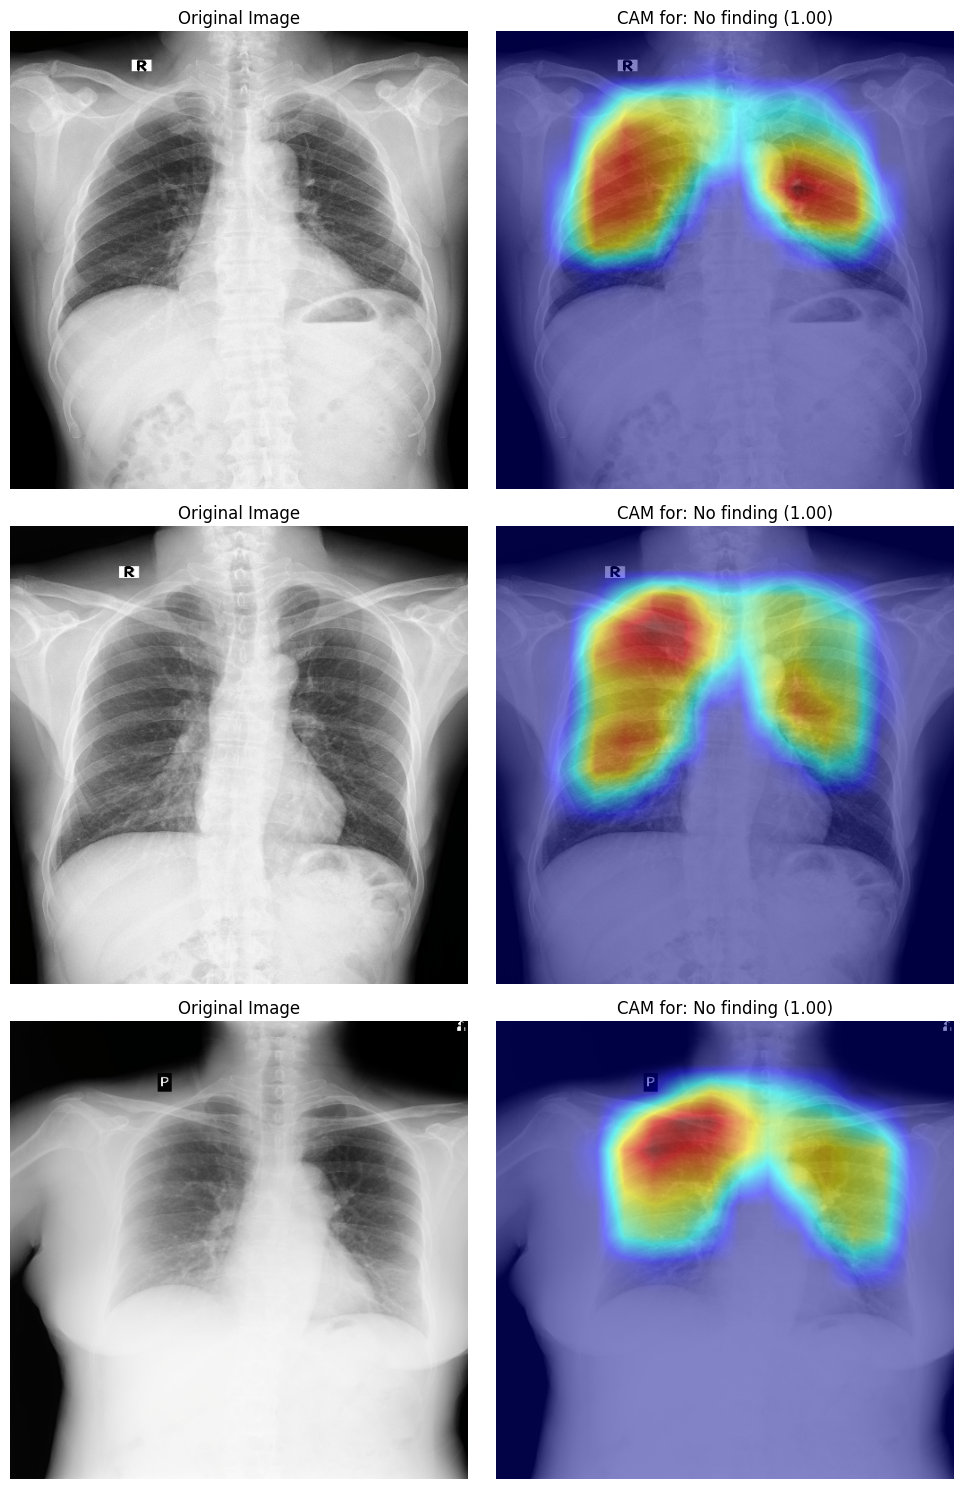

In [ ]:
# ==============================================================================
# Cell 9: Grad-CAM Visualization for Model Explainability
# ==============================================================================

# 1. Load the best model from the checkpoint path
if not checkpoint_callback.best_model_path:
    print("No best model found. Skipping Grad-CAM.")
else:
    # Use PyTorch Lightning's method to correctly load the model and its structure
    best_model = VinBigDataClassifier.load_from_checkpoint(
        checkpoint_path=checkpoint_callback.best_model_path,
        n_classes=CONFIG['N_CLASSES'],
        model_name=CONFIG['MODEL_NAME'],
        lr=CONFIG['LR']
    )
    best_model.eval() # Set model to evaluation mode
    
    # Define device and ensure the model and input tensor are on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device) # Move model to GPU/CPU

    # 2. Grad-CAM Setup 
    # Select the last convolutional block's batch normalization layer as the target for CAM
    target_layer = best_model.model._blocks[-1]._bn2

    # Instantiate GradCAM: it automatically detects the model's device
    cam = GradCAM(model=best_model, target_layers=[target_layer])

    # Denormalization required to convert the input tensor back to a displayable image
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(NORM_MEAN, NORM_STD)],
        std=[1/s for s in NORM_STD]
    )

    def visualize_gradcam(model, cam, dataset, n_samples=2):
        # Function to run inference, generate CAM, and plot the result
        fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5 * n_samples))
        if n_samples == 1: axes = axes[np.newaxis, :]
        
        for i in range(n_samples):
            # Select a random validation image
            idx = random.randint(0, len(dataset) - 1)
            input_tensor, target_vec = dataset[idx]
            
            # Prepare tensor for model (add batch dimension and move to device)
            input_tensor_batch = input_tensor.unsqueeze(0).to(model.device) 

            # Predict the class probabilities
            with torch.no_grad():
                logits = model(input_tensor_batch)
                probs = torch.sigmoid(logits).squeeze().cpu().numpy()
                
            # Target the class with the highest probability for the heatmap generation
            predicted_class_idx = np.argmax(probs)
            target_category = [ClassifierOutputTarget(predicted_class_idx)]

            # Generate the heatmap (grayscale_cam)
            grayscale_cam = cam(input_tensor=input_tensor_batch, targets=target_category)
            grayscale_cam = grayscale_cam[0, :]
            
            # Denormalize image for display
            rgb_img = inv_normalize(input_tensor)
            rgb_img = rgb_img.permute(1, 2, 0).cpu().numpy()
            rgb_img = np.clip(rgb_img, 0, 1)

            # Overlay the CAM onto the original image
            cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            # Plotting the original and the CAM-overlaid image
            axes[i, 0].imshow(rgb_img)
            axes[i, 0].set_title(f"Original Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(cam_image)
            axes[i, 1].set_title(
                f"CAM for: {idx_to_class[predicted_class_idx]} ({probs[predicted_class_idx]:.2f})"
            )
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

    # Run Visualization for 3 random samples
    visualize_gradcam(best_model, cam, val_dataset, n_samples=3)